# Exercise - Encoder Decoder Transformer
> "This exercise guides you to a full implementation of a transformer with Pytorch and HuggingFace."

- toc: false
- badges: true
- comments: true
- categories: [Attention is all you need, Transformer, Pytorch, NLP, Coding Exercise, HuggingFace]
- image: images/coding.png


"This exercise guides you to a [full implementation of a transformer](https://arxiv.org/pdf/1706.03762.pdf) with Pytorch and HuggingFace"

In [1]:
#hide
!pip install transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.4 MB/s 
     |████████████████████████████████| 101 kB 13.4 MB/s 
     |████████████████████████████████| 6.6 MB 34.0 MB/s 
     |████████████████████████████████| 596 kB 40.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Imports

In [2]:
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AutoConfig

from torch import nn
import torch.nn.functional as F
import torch
 
from math import sqrt

# Tokenizer 

Let's begin by looking at the tokenizer. It is essentially transforming your text into numerical values that your transformer will be able to "understand".

**Exercise:**
- Load the tokenizer for `bert-base-uncased` from HuggingFace
- `Tokenize` the following text and return it as a `PyTorch Tensor`: "time flies like an arrow"
- Print the `input ids` of the tokenized text



**Your Code:** 

**Solution:**

In [3]:
#collapse-hide collapse-output
model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
text = "time flies like an arrow"

inputs = tokenizer(text, return_tensors="pt", add_special_tokens=True)
inputs.input_ids

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

tensor([[  101,  2051, 10029,  2066,  2019,  8612,   102]])

# Model

Now, let's look at the architecture of the `bert-base-uncased` model. 
It is important that the `model checkpoint` is the same as the one you used to instantiate your tokenizer.

**Exercise:**
- Load the pretrained model from HuggingFace 
- Take a look at the architecture and answer the following questions:
  - How many `BertLayers` does the model have? 
  - What is the dropout probability in the `BertEmbeddings`?
  - What is the hidden dimension of the `position_embeddings`and `token_type_embeddings`?

**Your Code:** 

**Solution:**

#collapse-hide

Answers:
- How many BertLayers does the model have?
  - **12**
- What is the dropout probability in the BertEmbeddings?
  - **p=0.1 -> 10%**
- What is the hidden dimension of the position_embeddingsand token_type_embeddings?
  - **768**

In [4]:
#collapse-hide
model = AutoModel.from_pretrained(model_ckpt)
model

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

# Config

Another way to access the desired information about the model (and more) is by looking at the model configuration file provided by HuggingFace.

**Exercise:**
- Load the configuration file and take a look at the `config object`
- What `activation function`is being used on the hidden layers? 
- Find the `id` of the `pad_token`

**Your Code:** 

**Solution:**

In [ ]:
#collapse-hide
config = AutoConfig.from_pretrained(model_ckpt)
config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

# Self Attention

Let' unravel the driving force behind transformers, ow that we have looked at the `tokenizer`, `model` and the corresponding `config` file.
Let's look at `self-attention`.

Here you can see the basic attention calcualtion.
Think of $Q$, $K$ and $V$ as matrices/tensors.
In the case of langage models, these will have the corresponding shape $(\text{batch size}, \text{length of input sequence}, \text{embedding dimension})$ 
- $Q$ = query
- $K$ = key
- $V$ = value
- $d_k$ = hidden dimension of key

We call the calculation `cross-attention` if $Q$, $K$ and $V$ are different matrices. Conversely, we call it `self-attention` if $Q$, $K$ and $V$ are the same matrix e.g. $Q$ = $K$ = $V$ = $X$

$\text{Cross-Attention}(Q,K,V) = {softmax}(\frac{QK^T}{\sqrt d_k})V$


$\text{Self-Attention}(X_1,X_2,X_3) = {softmax}(\frac{XX^T}{\sqrt d_x})X$


**Exercise:**
- Complete the implementation of the `scaled_dot_product_attention` function

**Your Code:** 

In [ ]:
def scaled_dot_product_attention():
  """Example function with types documented in the docstring.

  Args:
      query (torch.tensor): Query tensor.
      key (torch.tensor): Key tensor.
      value (torch.tensor): Value tensor.

  Returns:
      attention (torch.tensor): Scaled dot product attention.
  """
  pass

**Solution:**

In [ ]:
#collapse-hide
def scaled_dot_product_attention(query: torch.tensor, 
                                 key: torch.tensor, 
                                 value: torch.tensor) -> torch.tensor: 
  """This function calculates the scaled dot product attention.
  It takes a query, key and value as input and returns a PyTorch tensor
  containing the attention values

  Args:
      query (torch.tensor): Query tensor.
      key (torch.tensor): Key tensor.
      value (torch.tensor): Value tensor.

  Returns:
      attention (torch.tensor): Scaled dot product attention.

  """
  dim_k = query.size(-1)
  scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
  weights = F.softmax(scores, dim=-1)
  attention = torch.bmm(weights, value)
  return attention

# Attention Head

In the image bellow you can see how the `scaled_dot_product_attention` function is being used in `Multi-Head Attention`.

A single `Attention Head` implements the parts until scaled dot product attention. The notion of multiple heads comes into play, once we add `h > 1` heads, `concatenate`them and apply a `Linear` function. 


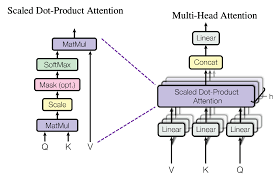

**Exercise:**
- Implement the `AttentionHead` class


**Your Code:** 

In [ ]:
class AttentionHead(nn.Module):
  """
  Implements a single attention head. Multiple heads can be concatenated  
  to obtain Multi-Head Attention.
  """
  
  def __init__(self):
    pass

  def forward(self):
    pass

**Solution:**

In [ ]:
#collapse-hide
class AttentionHead(nn.Module):
  """
  Implements a single attention head. Multiple heads can be concatenated  
  to obtain Multi-Head Attention.
  """
  
  def __init__(self, embed_dim: int, head_dim: int):
    super().__init__()
    self.q = nn.Linear(embed_dim, head_dim)
    self.k = nn.Linear(embed_dim, head_dim)
    self.v = nn.Linear(embed_dim, head_dim)
  
  def forward(self, hidden_state: torch.tensor) -> torch.tensor:
    attn_outputs = scaled_dot_product_attention(
        self.q(hidden_state), 
        self.k(hidden_state), 
        self.v(hidden_state))
    return attn_outputs

# Multi-Head Attention

Now we can use our single `Attention-Head` to implement the `Multi-Head Attention`. 

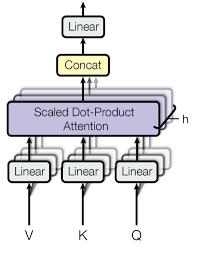

**Exercise:**
- Implement the `MultiHeadAttention` class

**Your Code:**

In [ ]:
class MultiHeadAttention(nn.Module):
  """Creates Multi-Head Attention Layer by
  determining embedding dimension, number of heads and 
  head dimension from the config file.
  """
  def __init__(self):
    pass
  
  def forward(self):
    pass

**Solution:**

In [ ]:
#collapse-hide
class MultiHeadAttention(nn.Module):
  """Creates Multi-Head Attention Layer by
  determining embedding dimension, number of heads and 
  head dimension from the config file.
  """
  def __init__(self, config: dict):
    super().__init__()
    embed_dim = config.hidden_size
    num_heads = config.num_attention_heads
    head_dim = embed_dim // num_heads
    self.heads = nn.ModuleList(
        [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
        )
    self.output_linear = nn.Linear(embed_dim, embed_dim)
  
  def forward(self, hidden_state: torch.tensor) -> torch.tensor:
    x = torch.cat([h(hidden_state) for h in self.heads], dim=-1)
    x = self.output_linear(x)
    return x

# Feed Forward 

Great, looking at the following diagram, we can see that we successfully implemented the orange `Multi-Head Attention` box. 

But that is only half of the picture. Let's implement the other parts of a Transformer Encoder.


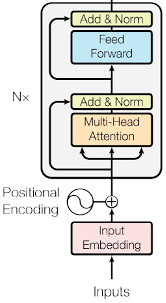

**Exercise:**
- Implement the `Feed Forward` class
- It should contain:
  - 2 linear layers with `hidden_size`and `intermediate_size` as found in the config file
  - A `GELU` activation function
  - A `Dropout`layer with the propper `dropout probability` 

**Your Code:** 

In [ ]:
class FeedForward(nn.Module):
  """Implements feed forward layer with GeLU
  and Dropout. Contains 2 Linear layers.
  """
  def __init__(self):
    pass
  def forward(self):
    pass

**Solution:**

In [ ]:
#collapse-hide
class FeedForward(nn.Module):
  """Implements feed forward layer with GeLU
  and Dropout. Contains 2 Linear layers.
  """
  def __init__(self, config: dict):
    super().__init__()
    self.linear_1 = nn.Linear(config.hidden_size, config.intermediate_size)
    self.linear_2 = nn.Linear(config.intermediate_size, config.hidden_size)
    self.gelu = nn.GELU()
    self.dropout = nn.Dropout(config.hidden_dropout_prob)

  def forward(self, x: torch.tensor) -> torch.tensor:
    x = self.linear_1(x)
    x = self.gelu(x)
    x = self.linear_2(x)
    x = self.dropout(x)
    return x

# Encoder Layer

With the `Multi-Head Attention` and `Feed Forward` classes in place, we can put together an entire `encoder layer`which corresponds to the gray box.


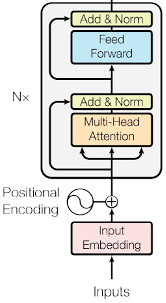

**Exercise:**
- Implement the `TransformerEncoderLayer` class
- It should contain:
  - `Multi-Head Attention` (orange box)
  - 2 `Layer Norms` (what we call `Norm`in the yellow box)
  - `Residual connections` (what we call `Add` in the yellow box)
  - `Feed Forward` layer (blue box)

**Your Code:**

In [ ]:
class TransformerEncoderLayer(nn.Module):
  """ Combines Multi-Head Attention with Layer Normalization, 
  Feed Forward Layer and skip connections to obtain an Encoder Layer.
  """
  def __init__(self):
    pass
  def forward(self):
    pass

**Solution:**

In [ ]:
#collapse-hide
class TransformerEncoderLayer(nn.Module):
  """ Combines Multi-Head Attention with Layer Normalization, 
  Feed Forward Layer and skip connections to obtain an Encoder Layer.
  """
  def __init__(self, config):
    super().__init__()
    self.layer_norm_1 = nn.LayerNorm(config.hidden_size)
    self.layer_norm_2 = nn.LayerNorm(config.hidden_size)
    self.attention = MultiHeadAttention(config)
    self.feed_forward = FeedForward(config)
  
  def forward(self, x):
    # Apply attention with a skip connection
    hidden_state = self.attention(x)

    # Apply layer normalization and then copy input into query, key, value
    intermediate_output = self.layer_norm_1(hidden_state + x)

    # Apply feed-forward layer with a skip connection
    output = self.layer_norm_2(intermediate_output + self.feed_forward(intermediate_output))
    return output

# Embeddings

We're nearly there. 

To give our transformer a chance at understanding our input tokens, we want to embedd the input token sequence into vectors. This way we can capture more information. 

Since data is fed to a transformer at once - unlike sequentially as in an RNN - it doesn't know anything about the position of words in a given sentence.
That's where the `positional encoding` comes in. It gives the transformer the ability to learn the positions. 


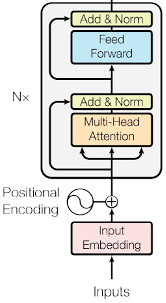


**Exercise:**
- Implement the `Embeddings` class
- It should contain:
  - `Token Embeddings` (pink box)
  - `Positional Embeddings` (Circle with sin wave)
  - `Dropout` 
  - `Layer Norm`

**Your Code:**

In [ ]:
class Embeddings(nn.Module):
  """Implements token embeddings and positional embbeddings. 
  """
  def __init__(self):
    pass
  
  def forward(self):
    pass

**Solution:**

In [ ]:
#collapse-hide
class Embeddings(nn.Module):
  """Implements token embeddings and positional embbeddings. 
  """
  def __init__(self, config: dict):
    super().__init__()
    self.token_embeddings = nn.Embedding(config.vocab_size,
                                         config.hidden_size)
    self.position_embeddings = nn.Embedding(config.max_position_embeddings,
                                            config.hidden_size)
    self.layer_norm = nn.LayerNorm(config.hidden_size, eps=1e-12)
    self.dropout = nn.Dropout()
  
  def forward(self, input_ids: torch.tensor) -> torch.tensor:
    # Create position IDs for input sequence
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long).unsqueeze(0)
    
    # Create token and position embeddings
    token_embeddings = self.token_embeddings(input_ids)
    position_embeddings = self.position_embeddings(position_ids)

    # Combine token and position embeddings
    embeddings = token_embeddings + position_embeddings
    embeddings = self.layer_norm(embeddings)
    embeddings = self.dropout(embeddings)
    return embeddings

# Transformer Encoder

Now for the full transformer Encoder the last missing piece is stacking up the `Encoder Layers`. In the diagram this is specified by `N x`


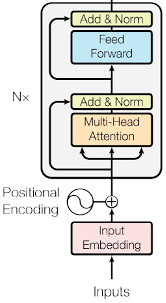


**Exercise:**
- Implement the `TransformerEncoder` class by combining the `Embeddings` and the `Transformer Encoder Layers` and stacking them up.



**Your Code:**

In [ ]:
class TransformerEncoder(nn.Module):
  """Combines the Embedding layer and multiple encoder layers  
   to obtain full transformer encoder.
  """  
  def __init__(self):
    pass
    
  def forward(self):
    pass

**Solution:**

In [ ]:
#collapse-hide
class TransformerEncoder(nn.Module):
  """Combines the Embedding layer and multiple encoder layers  
   to obtain full transformer encoder.
  """  
  def __init__(self, config):
    super().__init__()
    self.embeddings = Embeddings(config)
    self.layers = nn.ModuleList(
        [TransformerEncoderLayer(config)
        for _ in range(config.num_hidden_layers)])
  
  def forward(self, x):
    x = self.embeddings(x)
    for layer in self.layers:
      x = layer(x)
    return x

# Classification Head

Now that we have the transformer `body`, it'd be great to add a `head` and make the transformer do something useful. 

A common task in `classification`

**Exercise:**
- Implement the `TransformerForSequenceClassification` head by adding a `Linear` layer on top of the body. 
- Set the output size to the desired `number of class labels` 

**Your Code:**

In [ ]:
#collapse-hide
class TransformerForSequenceClassification(nn.Module):
  
  def __init__(self):
    pass
    
  def forward(self):
    pass

**Solution:**

In [ ]:
#collapse-hide
class TransformerForSequenceClassification(nn.Module):
  
  def __init__(self, config):
    super().__init__()
    self.encoder = TransformerEncoder(config)
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.classifier = nn.Linear(config.hidden_size, config.num_labels)
  
  def forward(self, x):
    x = self.encoder(x)[:, 0, :] # select hidden state of [CLS] token
    x = self.dropout(x)
    x = self.classifier(x)
    return x

# Masked Attention

Last but not least, if we wanted to implement the `Decoder` of a transformer, we'd need a way to mask our inputs. This is crucial, since the transformer could just `hack`the decoding task by looking at the next word and using it as it's prediciton. 

We can circumvent this issue by adding a mask to our `scaled_dot_product_attention` function.

**Exercise:**
- Create a maks as a lower triangular matrix with it's upper values set to `-inf`
- Change the `scaled_dot_product_attention` such that it can incorporate a mask. 

**Your Code:**

In [ ]:
# Define mask 


In [ ]:
def scaled_dot_product_attention(query: torch.tensor, key: torch.tensor, 
                                 value: torch.tensor, mask=None) -> torch.tensor:
  """This function calculates the scaled dot product attention.
  It takes a query, key and value as input and returns a PyTorch tensor
  containing the attention values.
  It includes a mask that can be used in a transformer decoder.

  Args:
      query (torch.tensor): Query tensor.
      key (torch.tensor): Key tensor.
      value (torch.tensor): Value tensor.
      mask (torch.tensor): Attention Mask.

  Returns:
      attention (torch.tensor): Scaled dot product attention.

  """
  pass

**Solution:**

In [ ]:
# Define mask 
a = torch.rand(1,5,768)
mask = torch.tril(a)
a.masked_fill(mask == 0, float('-inf'))

tensor([[[0.1540,   -inf,   -inf,  ...,   -inf,   -inf,   -inf],
         [0.2688, 0.3257,   -inf,  ...,   -inf,   -inf,   -inf],
         [0.3194, 0.7374, 0.0761,  ...,   -inf,   -inf,   -inf],
         [0.1208, 0.2583, 0.9070,  ...,   -inf,   -inf,   -inf],
         [0.2744, 0.5596, 0.4383,  ...,   -inf,   -inf,   -inf]]])

In [ ]:
#collapse-hide
def scaled_dot_product_attention(query: torch.tensor, key: torch.tensor, 
                                 value: torch.tensor, mask=None) -> torch.tensor:
  """This function calculates the scaled dot product attention.
  It takes a query, key and value as input and returns a PyTorch tensor
  containing the attention values.
  It includes a mask that can be used in a transformer decoder.

  Args:
      query (torch.tensor): Query tensor.
      key (torch.tensor): Key tensor.
      value (torch.tensor): Value tensor.
      mask (torch.tensor): Attention Mask.

  Returns:
      attention (torch.tensor): Scaled dot product attention.

  """
  dim_k = query.size(-1)
  scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
  
  if mask is not None:
    scores = scores.masked_fill(mask == 0, float("-inf"))
  
  weights = F.softmax(scores, dim=-1)
  return weights.bmm(value)

# Putting it all together: Encoder-Decoder Transformer

**Your Code:**

**Solution:**

In [ ]:
#collapse-hide